In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización de datos
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Modelo de ML métricas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.calibration import calibration_curve

# Explicación de modelo
import shap

# Extra
import pickle
import warnings

In [2]:
# Evitar que haya warnings
# Filter warinings
warnings.filterwarnings('ignore')

# Parámetros de matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'large'
matplotlib.rcParams["font.family"] = "serif"

In [3]:
# Lectura de datos
data = pd.read_csv('./primary_dataset_v5.csv', index_col=0)
descr = pd.read_csv('./primary_dataset_v5_descr.csv', index_col=0)

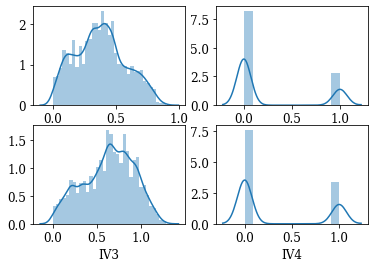

In [4]:
# Generación de variables de respuesta
data['IV'] = (data.IDA + data.ICA)/2
plt.subplot(2,2,1)
sns.distplot(data.IV)

data.loc[data.IV>.5, 'IV2'] = 1
data.loc[data.IV<=.5, 'IV2'] = 0
plt.subplot(2,2,2)
sns.distplot(data.IV2)

data['IV3'] = (data.IDA**2+data.ICA**2)**(1/2)
plt.subplot(2,2,3)
sns.distplot(data.IV3)

data.loc[data.IV3>.8, 'IV4'] = 1
data.loc[data.IV3<=.8, 'IV4'] = 0
plt.subplot(2,2,4)
sns.distplot(data.IV4)

0.9671878496395498
0.9395730388678725


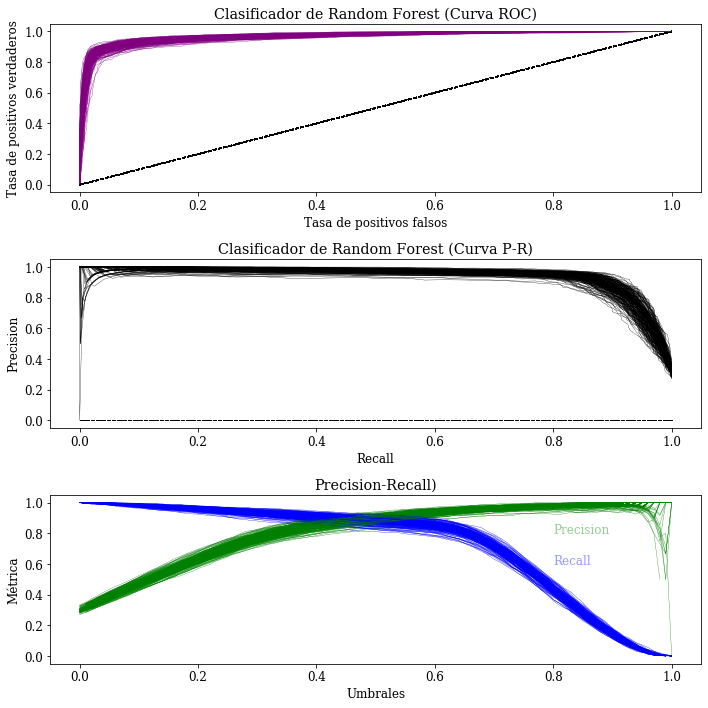

In [5]:
metric_roc_auc=[]
metric_prc_aps=[]

iteration_number=[]
best_model = dict()
plt.figure(figsize=(10,10))
# Esto está en un for para probar el modelo varias veces y determinar las métricas
# importante (al inicio no se debe de poner un número mayor a 200)
for i in range(200):
    # Sólo se consideran variables numéricas
    X = data.select_dtypes(include='number')
    
    # Generar un identificador único para cada geolocalización 
    X['unique'] = X.longitud.apply(str) + X.latitud.apply(str)
    
    # Indicar la variable de respuesta
    yvar ='IV2'
    
    # Generar la estratificación de ambos valores
    non = X[X[yvar]==0]
    con = X[X[yvar]==1]
    
    # Crear listas de los valores únicos en cada estrato 
    # (esto es importante para no tener feature leackage) 
    unique_locations_non = non['unique'].unique()
    unique_locations_con = con['unique'].unique()
    
    # De esa lista, generar de manera aleatoria (sin reemplazo) los valores que serán utilizados para entrenar
    # tomando en cuenta la proporción deseada
    proportion = 0.8
    X_train_index_non = list(np.random.choice(unique_locations_non,
                                              int(proportion*len(unique_locations_non)),
                                              replace=False))
    X_train_index_con = list(np.random.choice(unique_locations_con,
                                              int(proportion*len(unique_locations_con)),
                                              replace=False))
    
    # Todos aquellos valores que no fueron tomados serán usados como test
    X_test_index_non = list(set(unique_locations_non)-set(X_train_index_non))
    X_test_index_con = list(set(unique_locations_con)-set(X_train_index_con))
    
    # Una vez que hayamos hecho esa separación podemos juntarlos en una lista grande
    X_test_index = X_test_index_con + X_test_index_non
    X_train_index = X_train_index_con + X_train_index_non
    
    """CASO OMISO A ESTE PEDAZO
    #unique_locations = list(X['unique'].unique())
    #X_train_index = np.random.choice(unique_locations, int(.8*len(unique_locations)), replace=False)
    #X_test_index = list(set(unique_locations)-set(X_train_index))
    """
    # Ponemos una lista de las variables químicas (que no serán predictores)
    chem_vars = ["n_tot","so4_tot", "na_tot", "k_tot", "sio2", "ca_tot", "mg_tot", "alc_tot",
                "hco3", "n_no2", "p_tot", "cloruros_tot", "po4_tot", "n_nh3","n_totk", "co3", "ss_uso_tot"]
    
    # Sacamos de nuestros datos aquellas que tampoco serán predictores
    non_predictor_vars = ['unique','IV','ICA','IDA', 'IV2','IV3','IV4','año', 'time'] + chem_vars

    # Hacemos el test:
    # Tomamos en cuenta los valores del dataset que se encuentran en la lista grande
    # también los revolvemos para no depender de algún orden (sample hace esto)
    xtest = X[X['unique'].isin(X_test_index)].sample(frac=1)
    # Agarramos la variable de salida y la ponemos en nuestro y_test para posteriormente hacer métricas
    ytest = xtest[yvar]
    # Finalmente nos deshacemos de todas las variables que no queremos utilizar para predecir
    xtest = xtest.drop(non_predictor_vars, axis=1)

    # Hacemos mismo procedimiento para entrenar el modelo
    xtrain = X[X['unique'].isin(X_train_index)].sample(frac=1)
    ytrain= xtrain[yvar]
    xtrain = xtrain.drop(non_predictor_vars, axis=1)

    """CASO OMISO A ESTE PEDAZO
    #xgb = xgboost.XGBClassifier(learning_rate=0.01,
    #                                scale_pos_weight=1/5.3,
    #                                max_depth=4,
    #                                n_estimators=200,
    #                                subsample=1,
    #                                colsample_bytree=.5,
    #                                reg_lambda=0.6,
    #                                reg_alpha=.06)
    """
    # Implementación del modelo
    #(los hiperparámetros fueron determinados de manera recursiva corriendo este código varias veces)
    # y nos quedamos con el mejor desempeño
    rfc = RandomForestClassifier(n_estimators=100,
                                 criterion="entropy",
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features='auto',
                                 max_leaf_nodes=None,
                                 class_weight='balanced_subsample')
    # Entrenamiento del modelo (sklearn no recibe valores nulos, vamos a reemplazarlos por -10 ya que no hay 
    # muchos datos negativos en nuestro dataset)
    rfc.fit(xtrain.fillna(-10), ytrain)
    
    # Predecimos el valor final de nuestro resultado
    ypred = rfc.predict_proba(xtest.fillna(-10))[:,1]
    
    # Guardamos las iteraciones en una lista
    iteration_number.append(i)
    
    # Métrica 1: ROC y AUC-ROC
    # Generamos una curva por cada iteración
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    plt.subplot(311)
    plt.plot(fpr, tpr,linewidth=.3, color='purple')
    plt.plot([0,1],[0,1], color='k', linewidth=1, linestyle='--')
    plt.title("Clasificador de Random Forest (Curva ROC)")
    plt.xlabel("Tasa de positivos falsos")
    plt.ylabel("Tasa de positivos verdaderos")
    
    #Determinamos una métrica (en este caso rocAUC)
    auc = roc_auc_score(ytest, ypred)
    # Guardamos la métrica en una lista
    metric_roc_auc.append(auc)
    
    # Métrica 2: average_precision_score
    precision, recall, thresholds = precision_recall_curve(ytest, ypred)
    plt.subplot(312)
    plt.plot(recall, precision, linewidth=.3, color='k')
    plt.title("Clasificador de Random Forest (Curva P-R)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.plot([0,1],[0,0], color='k', linewidth=1, linestyle='--')
    
    aps = average_precision_score(ytest, ypred)
    metric_prc_aps.append(aps)
    
    # Otra visualización
    plt.subplot(313)
    plt.plot(thresholds, precision[:-1], linewidth=.3, c='g', label='precision')
    plt.plot(thresholds, recall[:-1], linewidth=.3, c='b', label='recall')
    plt.title("Precision-Recall)")
    plt.xlabel("Umbrales")
    plt.ylabel("Métrica")
    
    # Seleccionar modelo con maximo desempeño
    if len(metric_roc_auc) >= 2:
        if metric_roc_auc[-2] >= metric_roc_auc[-2]:
            best_model['model'] = rfc
            best_model['train'] = (xtrain, ytrain)
            best_model['test'] = (xtest, ytest)
        
plt.subplot(313)
plt.text(0.8,0.8,'Precision', c='g', alpha=.4)
plt.text(0.8,0.6,'Recall', c='b', alpha=.4 )

plt.tight_layout()
print(np.mean(metric_roc_auc))
print(np.mean(metric_prc_aps))

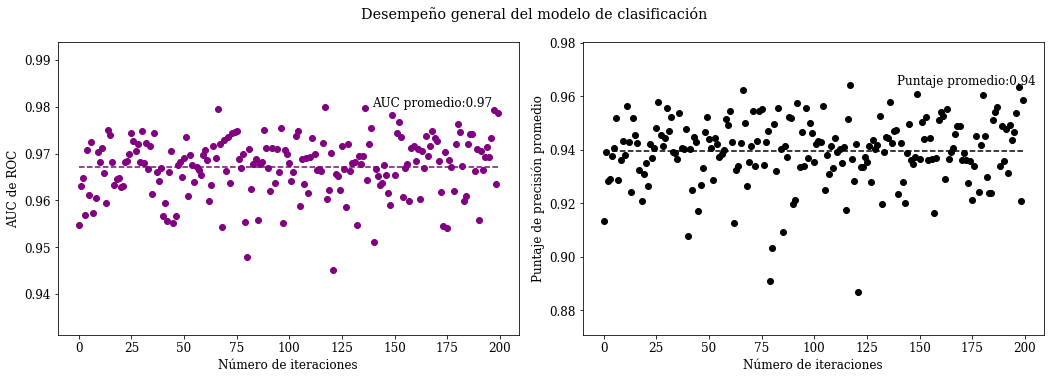

In [6]:
plt.figure(figsize=(15, 5))
plt.suptitle('Desempeño general del modelo de clasificación', y=1.05)

plt.subplot(121)
plt.scatter(iteration_number, metric_roc_auc, c='purple')
plt.plot([0,max(iteration_number)],
         [np.mean(metric_roc_auc)]*2,
         linestyle='--',
         c='purple')
plt.text(x =.7*max(iteration_number),
         y = max(metric_roc_auc),
         s = f'AUC promedio:{round(np.mean(metric_roc_auc), 2)}')
plt.xlabel('Número de iteraciones')
plt.ylabel('AUC de ROC')

plt.subplot(122)
plt.scatter(iteration_number, metric_prc_aps, c='k')
plt.plot([0,max(iteration_number)],
         [np.mean(metric_prc_aps)]*2,
         linestyle='--',
         c='k')
plt.text(x =.7*max(iteration_number),
         y = max(metric_prc_aps),
         s = f'Puntaje promedio:{round(np.mean(metric_prc_aps), 2)}')
plt.xlabel('Número de iteraciones')
plt.ylabel('Puntaje de precisión promedio')


plt.tight_layout()

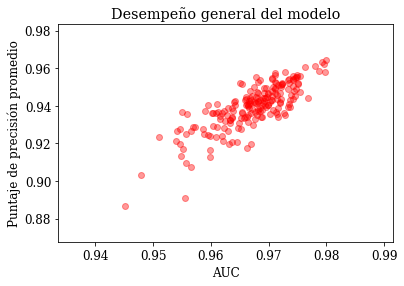

In [21]:
plt.scatter(metric_roc_auc,
            metric_prc_aps,
            c='r', alpha=.4)
plt.title('Desempeño general del modelo')
plt.xlabel('AUC')
plt.ylabel('Puntaje de precisión promedio')
plt.show()

In [8]:
y_pred = best_model['model'].predict_proba(best_model['test'][0].fillna(-10))[:, 1]
y_test = best_model['test'][1]

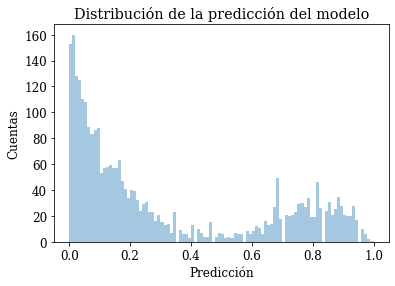

In [9]:
ans = pd.DataFrame([list(y_test),
                    list(y_pred)]).T

ans.columns = ['IV4','predict_proba']
sns.distplot(ans.predict_proba, kde=False, bins=100, label="0: No Viable")
plt.xlabel('Predicción')
plt.ylabel('Cuentas')
plt.title('Distribución de la predicción del modelo')
plt.show()

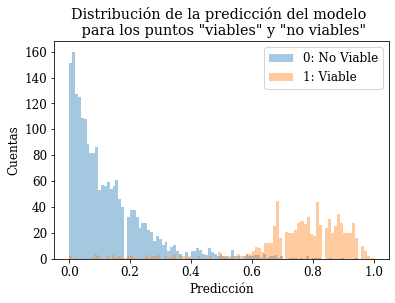

In [10]:
sns.distplot(ans[ans.IV4==0].predict_proba, kde=False, bins=100, label="0: No Viable")
sns.distplot(ans[ans.IV4==1].predict_proba, kde=False, bins=100, label='1: Viable')
plt.xlabel('Predicción')
plt.ylabel('Cuentas')
plt.title('Distribución de la predicción del modelo \n para los puntos "viables" y "no viables"')
plt.legend()
plt.show()

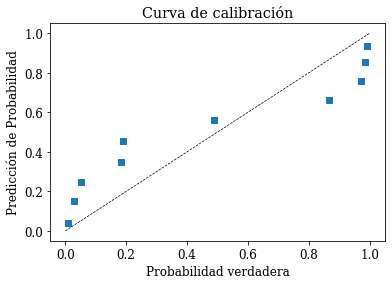

In [25]:
binned_true_p, binned_predict_p = calibration_curve(y_test,y_pred, n_bins=10)

plt.scatter(binned_true_p, binned_predict_p, marker='s')
#plt.plot(binned_true_p, binned_predict_p, marker='s')

plt.plot([0,1],[0,1], color='k', linewidth=.7, linestyle='--')
plt.title('Curva de calibración')
plt.xlabel('Probabilidad verdadera')
plt.ylabel('Predicción de Probabilidad')
plt.show()

In [12]:
# Inicialización del explicador SHAP
shap_ex = shap.TreeExplainer(best_model['model'])

In [13]:
# Agarrar las variables predictoras del modelo
x_test = best_model['test'][0].fillna(-10)

# Crear los valores shapley de estas variables
shap_values = shap_ex.shap_values(x_test)

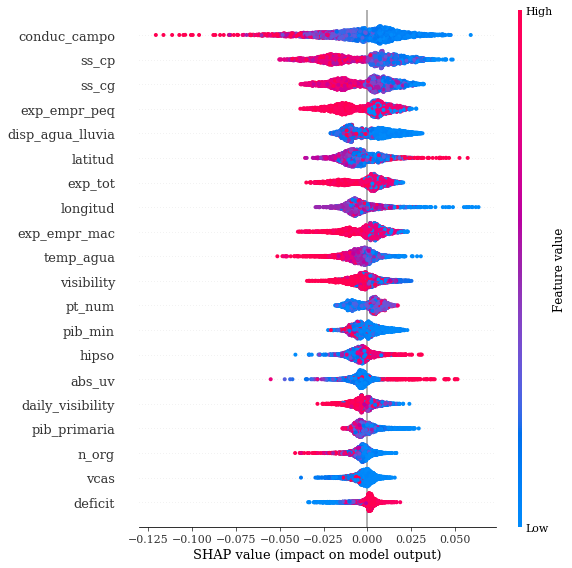

In [14]:
shap.summary_plot(shap_values[1], x_test)

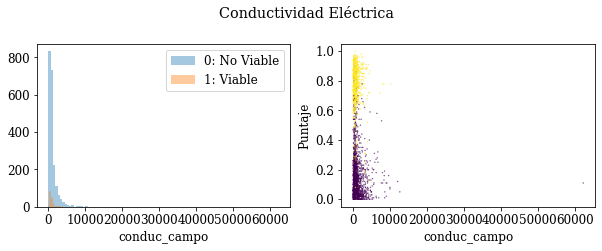

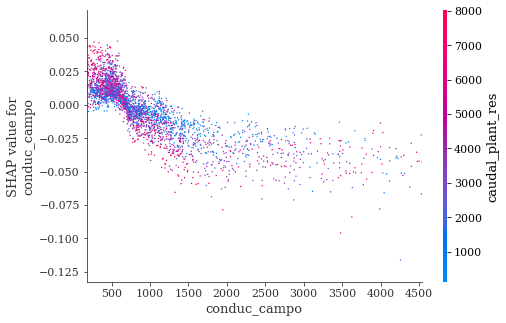

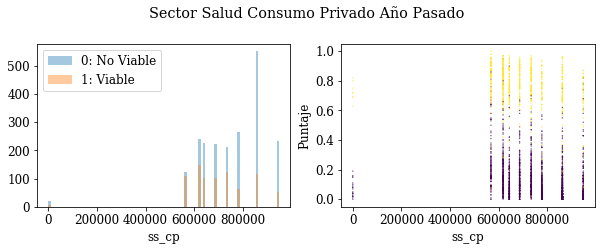

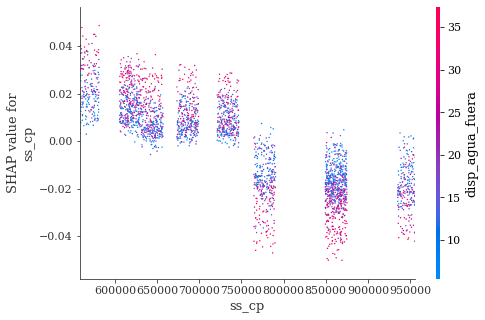

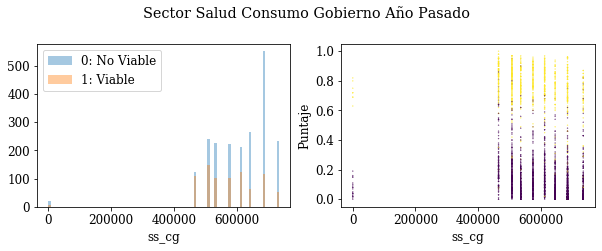

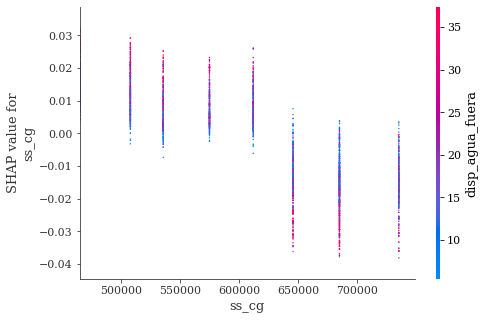

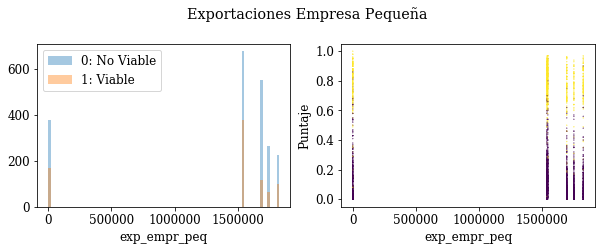

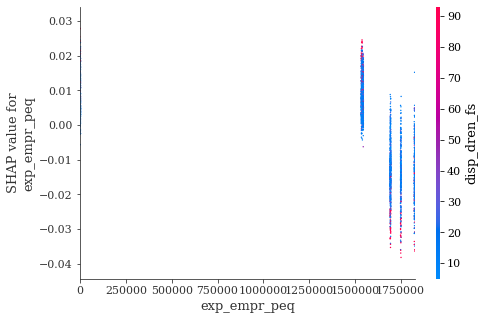

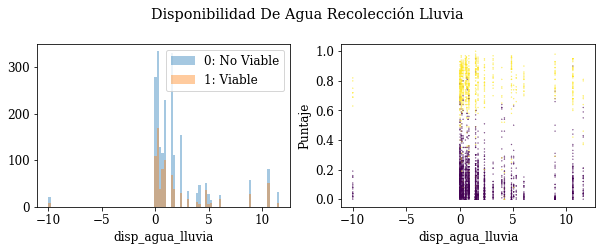

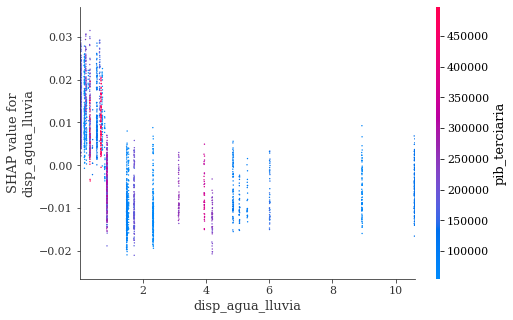

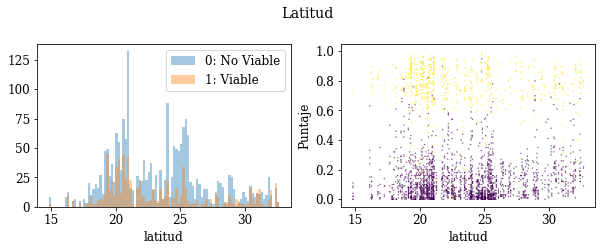

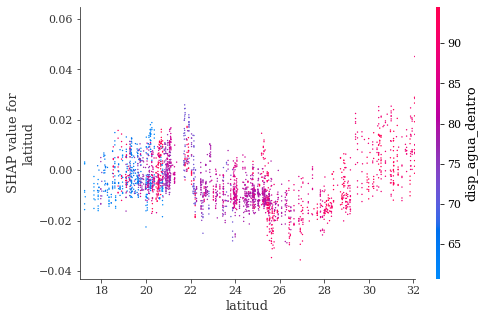

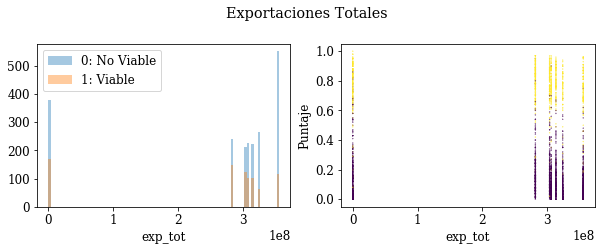

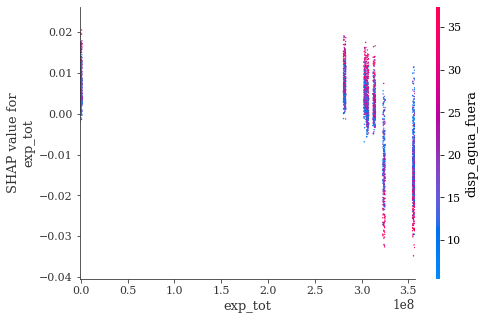

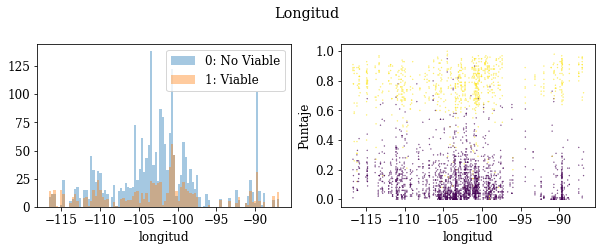

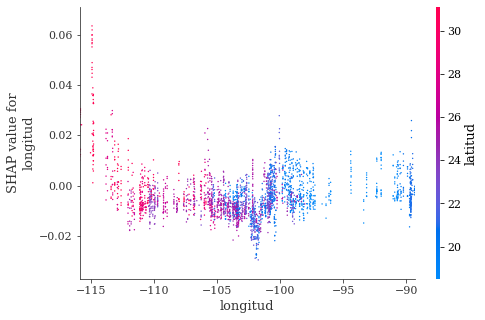

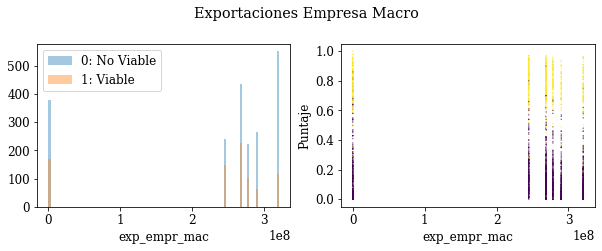

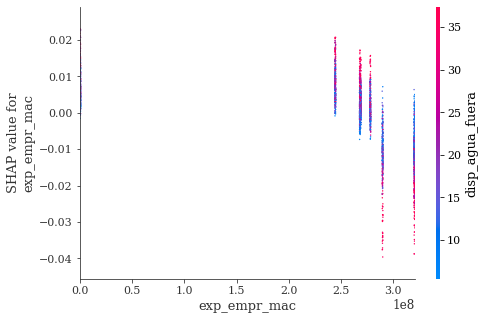

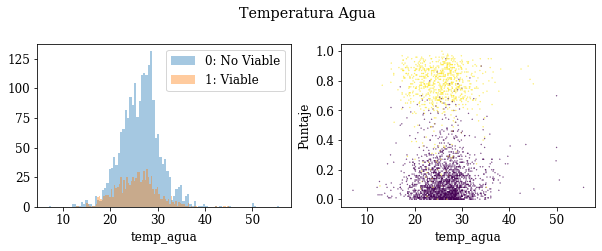

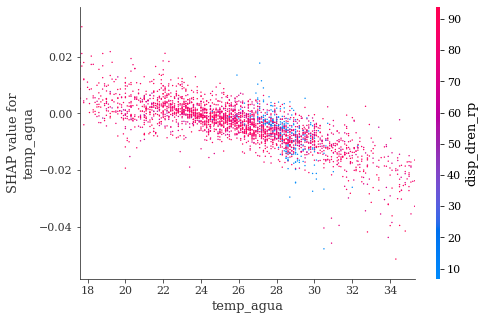

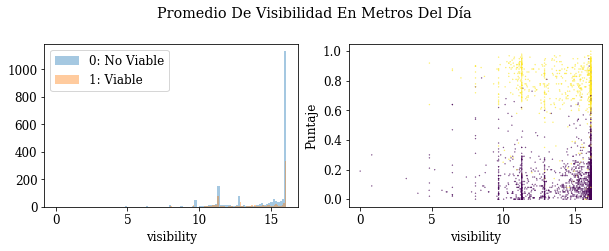

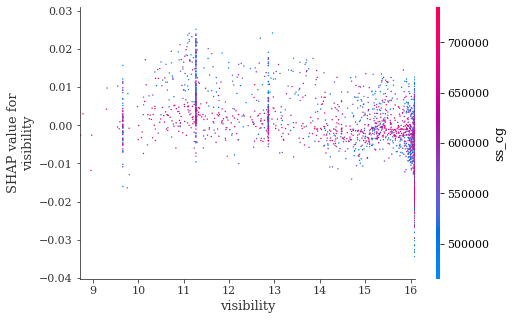

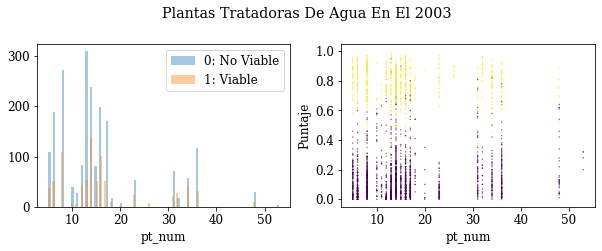

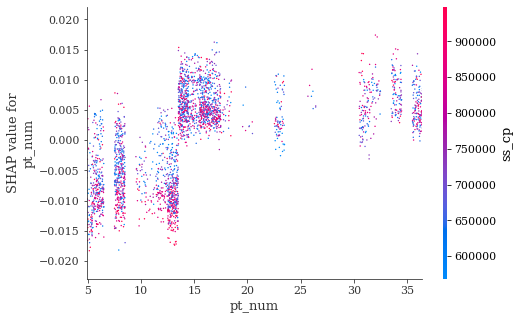

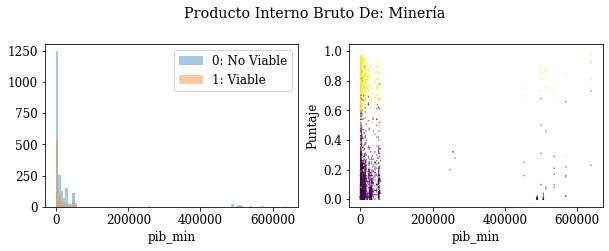

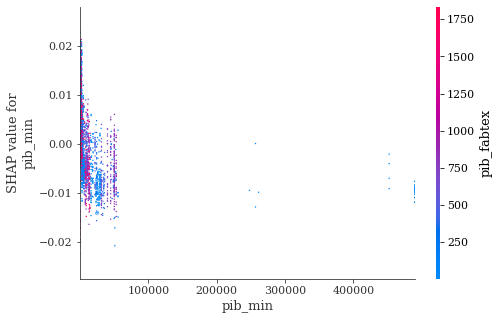

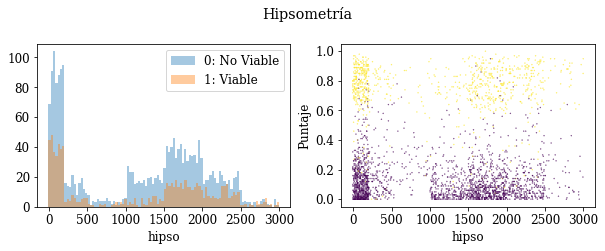

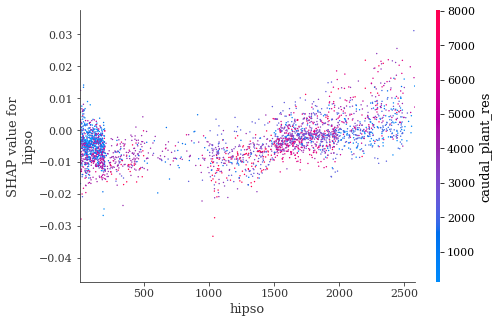

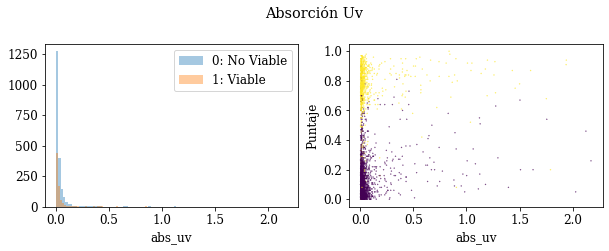

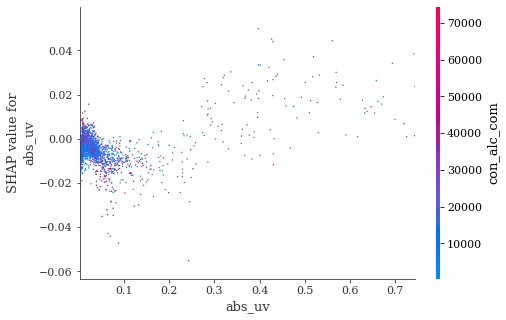

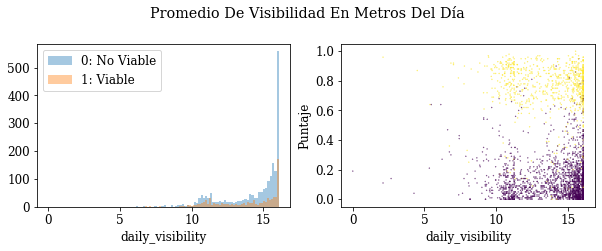

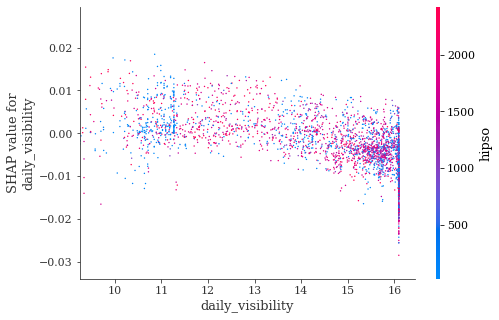

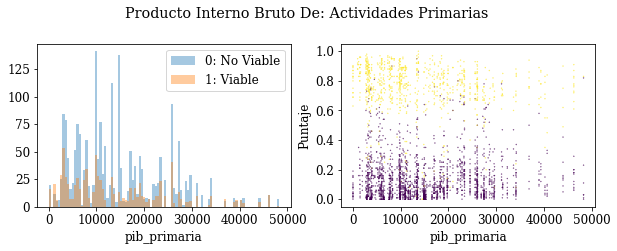

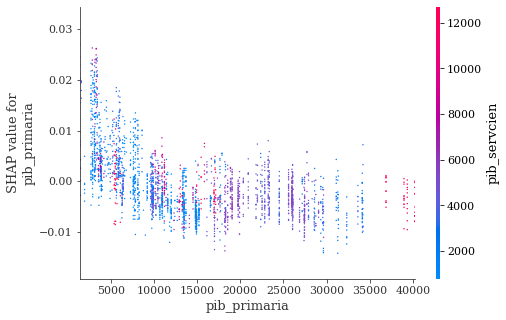

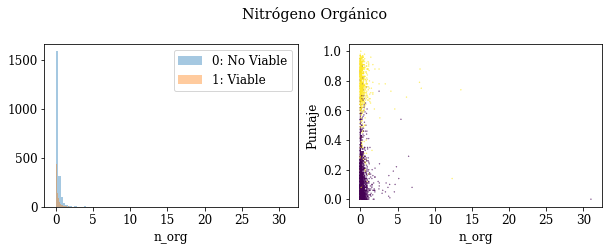

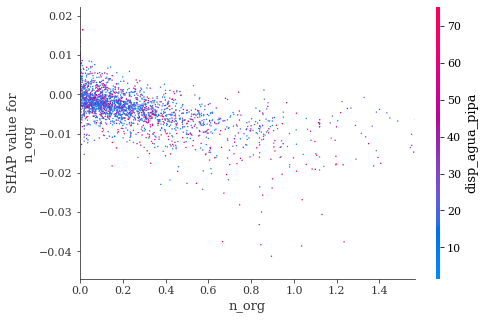

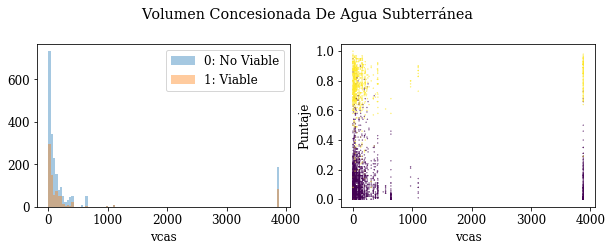

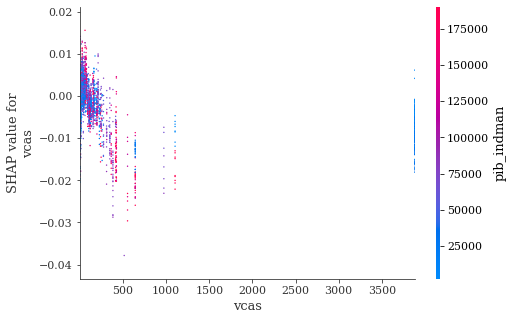

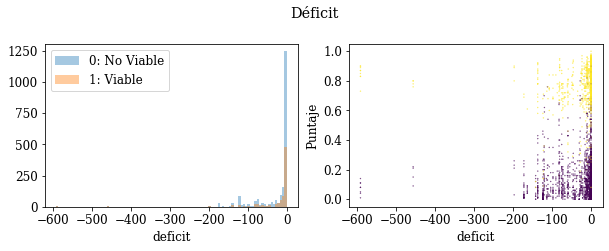

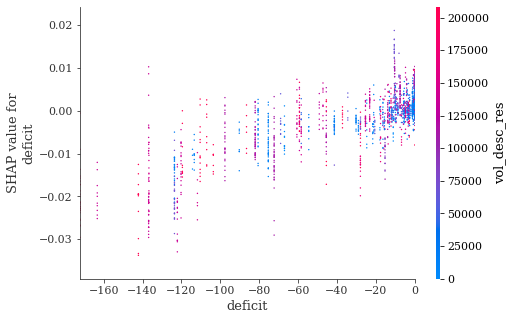

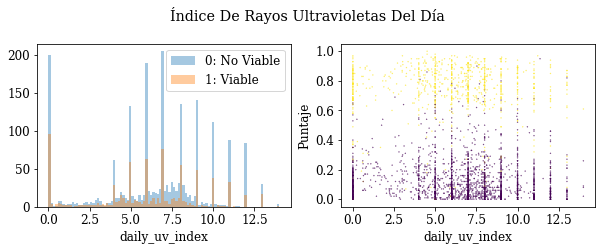

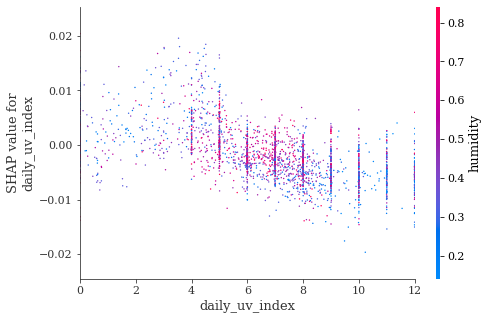

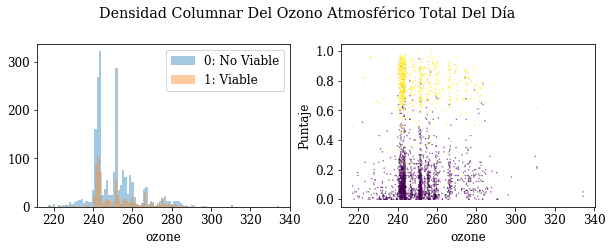

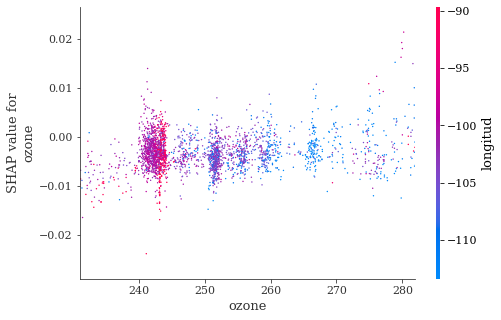

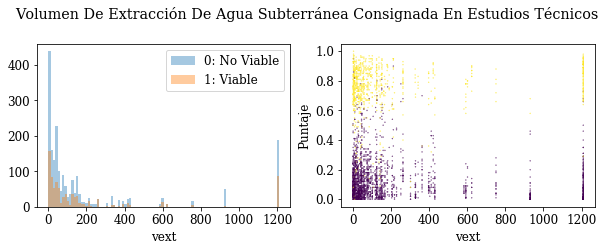

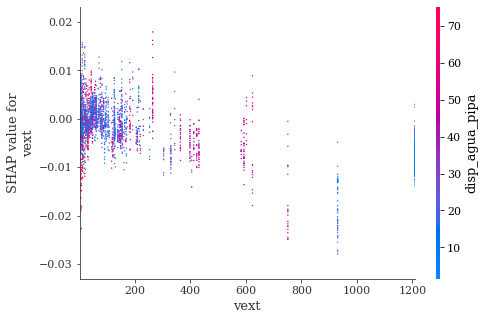

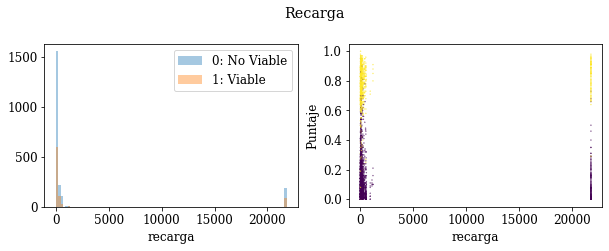

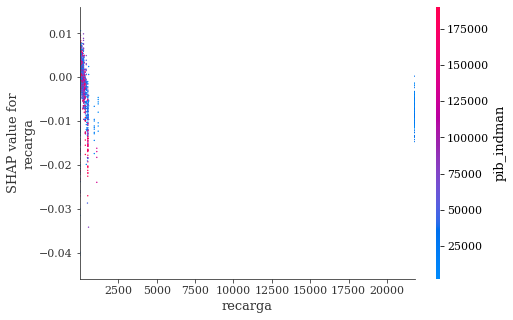

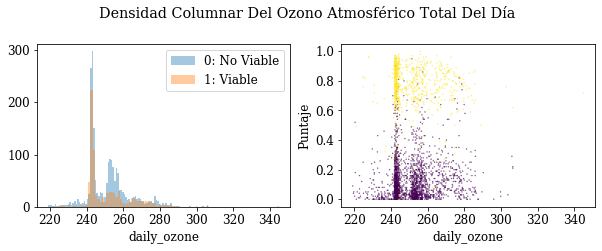

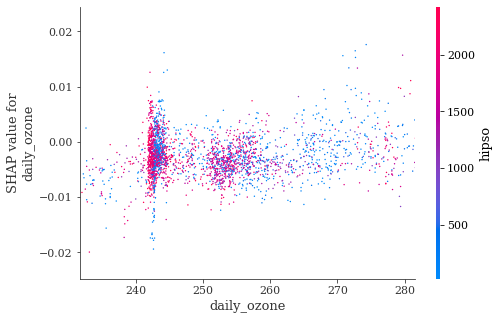

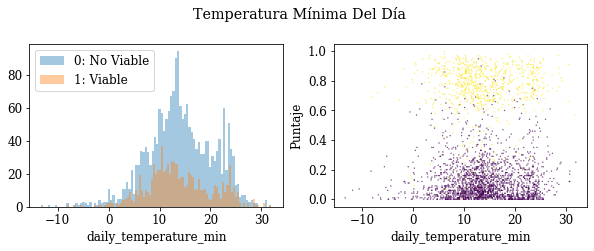

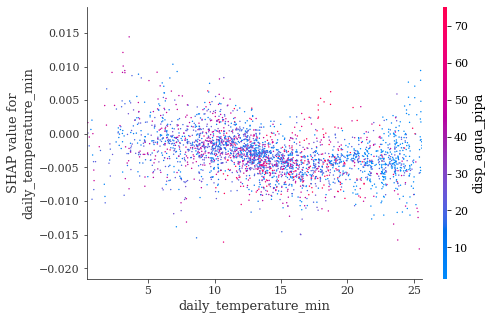

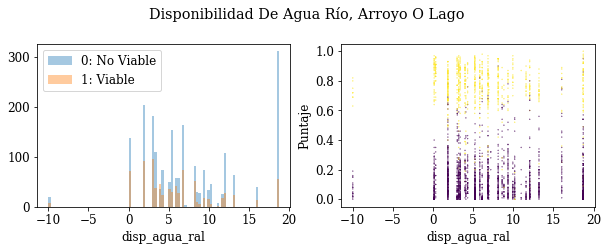

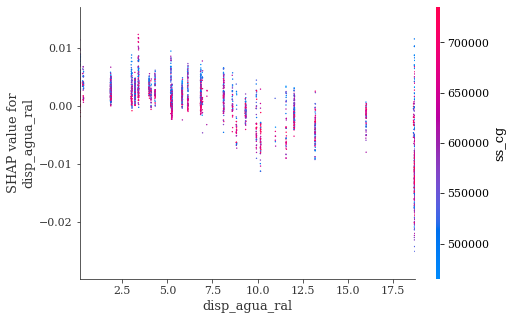

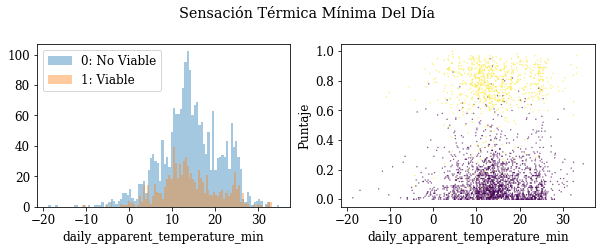

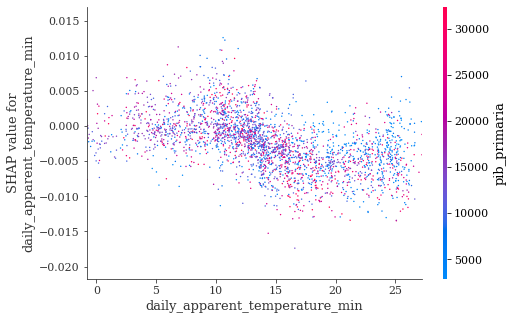

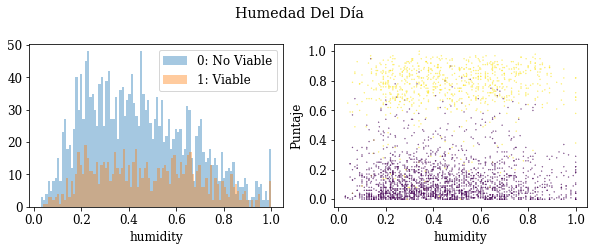

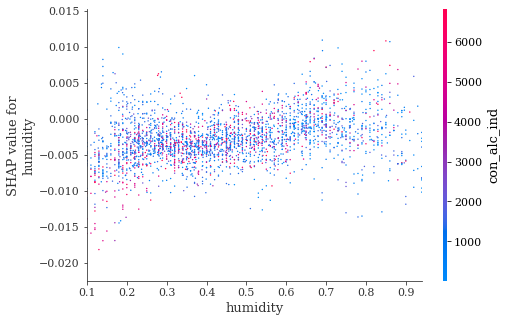

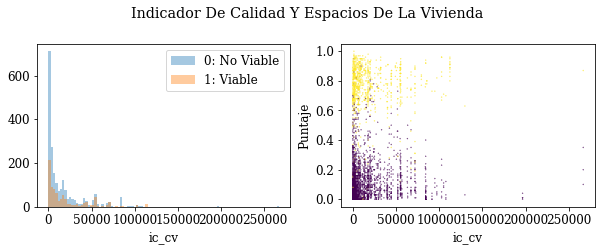

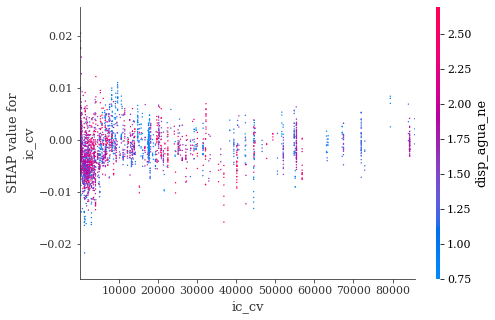

In [15]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))
name_list = x_test.columns
description_list = []
# make SHAP plots of the most important features
for i in range(30):
    description_list.append(name_list[top_inds[i]])
    # Distribuciones
    plt.figure(figsize=(10,3))
    plt.suptitle(descr[descr.CLAVE.str.contains(name_list[top_inds[i]])]['PARÁMETROS'].iloc[0].title(), y=1.05)
    plt.subplot(121)
    non = x_test[y_test==0][name_list[top_inds[i]]]
    yes = x_test[y_test==1][name_list[top_inds[i]]]
    sns.distplot(non, kde=False, bins=100, label="0: No Viable")
    sns.distplot(yes, kde=False, bins=100, label="1: Viable")
    plt.legend()
    plt.subplot(122)
    temp_df = pd.DataFrame()
    temp_df['x_test'] = list(x_test[name_list[top_inds[i]]])
    temp_df['y_pred'] = list(y_pred)
    temp_df['y_test'] = list(y_test)
    plt.scatter(temp_df['x_test'], temp_df['y_pred'], c=temp_df['y_test'], s=.1)
    plt.xlabel(name_list[top_inds[i]])
    plt.ylabel('Puntaje')
    plt.show()
    shap.dependence_plot(top_inds[i],
                         shap_values[1],
                         x_test,
                         #interaction_index=None,
                         xmin="percentile(2)",
                         xmax="percentile(98)",
                        dot_size=2,
                        x_jitter=1)



In [16]:
i=51
best_model['model'].predict_proba(x_test.iloc[i:i+1])

array([[0.86, 0.14]])

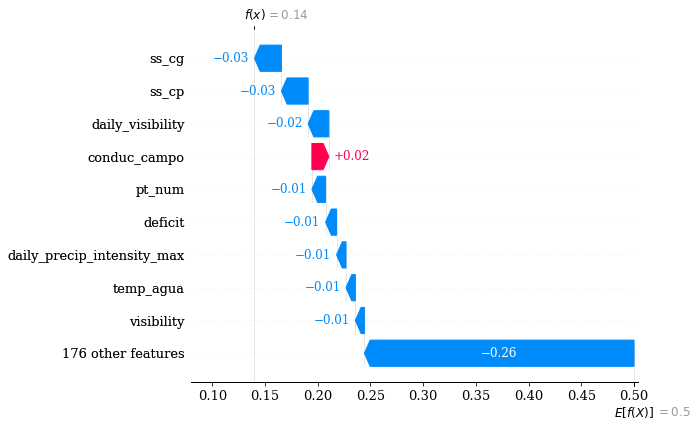

In [17]:
shap.waterfall_plot(shap_ex.expected_value[1],
                    shap_values[1][i],
                    feature_names=x_test.columns,)


In [18]:
shap.initjs()
shap.force_plot(shap_ex.expected_value[1],
                    shap_values[1][i],
                    feature_names=xtrain.columns)

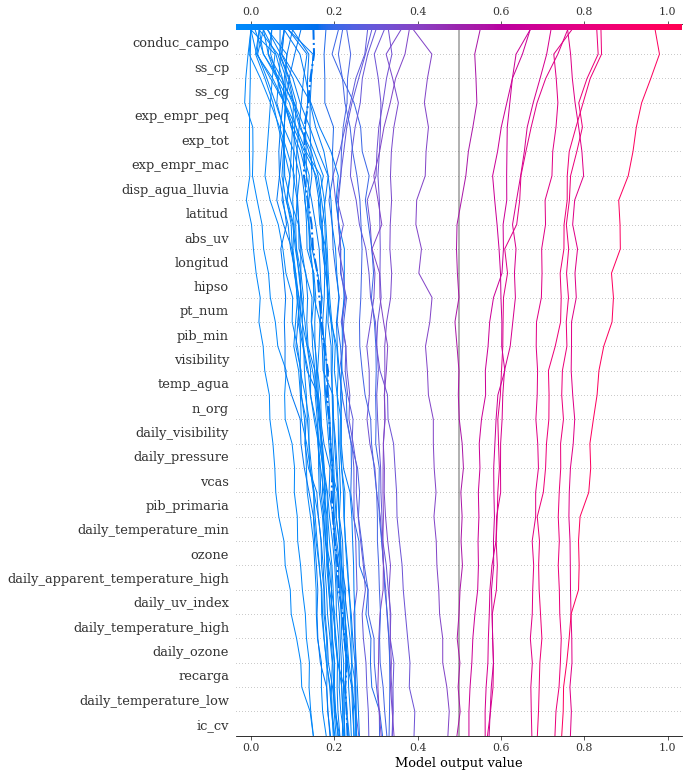

In [19]:
ith = 0
shap.decision_plot(shap_ex.expected_value[1],
                   shap_values[1][0+ith:ith+50],
                   feature_names=list(x_test.columns),
                   highlight=0,
                   feature_display_range=slice(None, -30, -1))

In [26]:
with open('classification_model.pkl', 'wb') as file:
    pickle.dump(best_model['model'], file)